In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
import torch

import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer.autoguide.guides import AutoNormal, AutoDelta

from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI

/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import cellij

In [5]:
pyro.enable_validation(True)

In [6]:
from tqdm import tqdm

In [7]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using matplotlib backend: <object object at 0x7f2075d8e560>


In [8]:
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1.0,
    rc={"lines.linewidth": 5},
)

In [9]:
from cellij.core.synthetic import DataGenerator

In [10]:
n_samples = [101, 102, 103]
n_features = [401, 402, 403]
dg = DataGenerator(n_samples, n_features)
rng = dg.generate(all_combs=True)

Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.
Generating all possible binary combinations of 3 variables.
New factor configuration across `samples` groups: 1 fully shared, 3 partially shared, 3 private factors.
Generating all possible binary combinations of 3 variables.
New factor configuration across `features` groups: 1 fully shared, 3 partially shared, 3 private factors.


In [11]:
sample_offsets = [0] + np.cumsum(n_samples).tolist()
feature_offsets = [0] + np.cumsum(n_features).tolist()

In [12]:
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal and/or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

<Axes: >

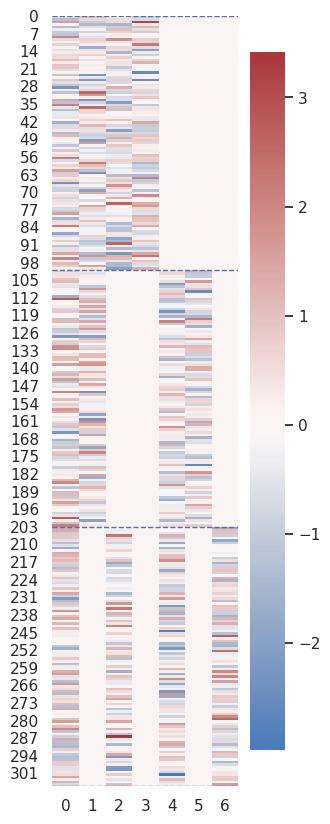

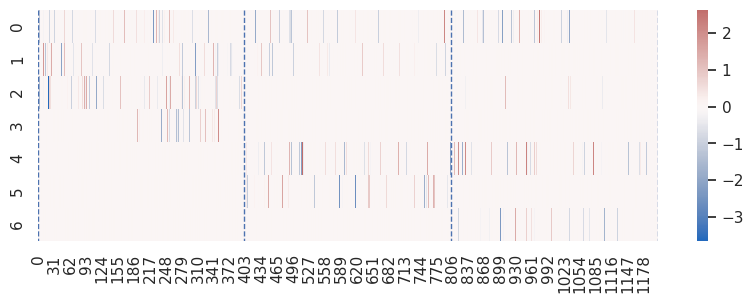

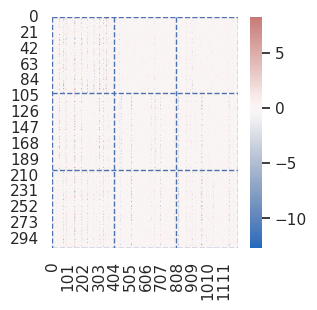

In [13]:
lined_heatmap(dg.z, figsize=(dg.n_sample_groups,10), hlines=sample_offsets, cmap="vlag", center=0)
lined_heatmap(dg.w, figsize=(10,dg.n_feature_groups), vlines=feature_offsets, cmap="vlag", center=0)
lined_heatmap(dg.y, figsize=(dg.n_sample_groups,dg.n_feature_groups), hlines=sample_offsets, vlines=feature_offsets, cmap="vlag", center=0)

In [14]:
model = cellij.core._pyro_models.Generative(
    n_factors=dg.n_factors,
    obs_dict={f"group_{g}": dg.n_samples[g] for g in range(dg.n_sample_groups)},
    feature_dict={f"view_{m}": dg.n_features[m] for m in range(dg.n_feature_groups)},
    likelihoods={f"view_{m}": "Normal" for m in range(dg.n_feature_groups)},
    factor_priors={
        "group_0": "Normal",
        "group_1": "Laplace",
        "group_2": "Horseshoe",
    },
    weight_priors={
        "view_0": "Normal",
        "view_1": "Laplace",
        "view_2": "Horseshoe",
    },
    device=torch.device("cuda:3"),
)


In [15]:
# def fa_model(data=None):
    
#     N = data.shape[0]
#     D = data.shape[1]
#     K = dg.n_factors

#     sample_plate = pyro.plate("sample", N, dim=-3)
#     factor_plate = pyro.plate("factor", K, dim=-2)
#     feature_plate = pyro.plate("feature", D, dim=-1)
    
#     with sample_plate, factor_plate:
#         z = pyro.sample("z", dist.Normal(torch.zeros(1), torch.ones(1))).squeeze()

#     with factor_plate, feature_plate:
#         w = pyro.sample("w", dist.SoftLaplace(torch.zeros(1), 0.1 * torch.ones(1))).squeeze()

#     with feature_plate:
#         sigma = pyro.sample("sigma", dist.InverseGamma(torch.ones(1), torch.ones(1)))
#         # sigma = torch.sqrt(sigma)

#     with sample_plate:

#         x = pyro.sample(
#             "x",
#             dist.Normal(torch.matmul(z, w), torch.ones(1)),
#             obs=data,
#             infer={"is_auxiliary": True},
#         )

#     return {"x": x, "z": z, "w": w, "sigma": sigma}

In [16]:
data = {
    f"group_{g}": {
        f"view_{m}": torch.Tensor(dg.ys[g][m]).to(model.device) for m in range(dg.n_feature_groups)
    }
    for g in range(dg.n_sample_groups)
}

Cleaning parameter store


100%|██████████| 2000/2000 [02:34<00:00, 12.91it/s, ELBO=475]  


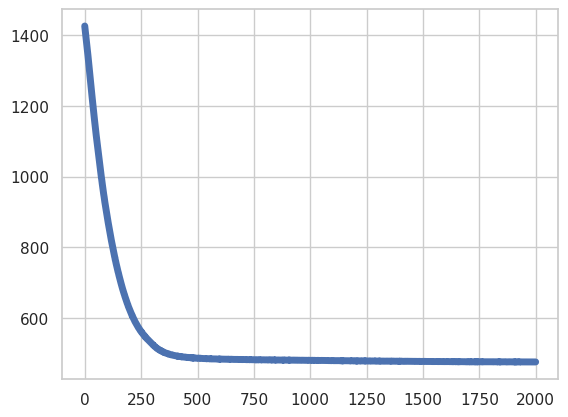

In [17]:
lr = 0.01
n_iterations = 2000
clipped = True

# clean start
print("Cleaning parameter store")
pyro.clear_param_store()

# autonormal_guide = AutoNormal(model)
guide = cellij.core._pyro_guides.Guide(model)


optim = Adam({"lr": lr, "betas": (0.95, 0.999)})
if clipped:
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / n_iterations)})

scale = 1.0 / sum(dg.n_samples)
svi = SVI(
    pyro.poutine.scale(model, scale=scale),
    pyro.poutine.scale(guide, scale=scale),
    optim=optim,
    loss=pyro.infer.TraceMeanField_ELBO(
            retain_graph=True,
            num_particles=20,
            vectorize_particles=True,
        )
,
)


elbo_history = []
pbar = tqdm(range(n_iterations))
for iteration_idx in pbar:
    elbo = svi.step(data)
    elbo_history.append(elbo)
    pbar.set_postfix({"ELBO": elbo})

plt.plot(elbo_history)

In [18]:
pyro.get_param_store().get_all_param_names()

dict_keys(['NormalQ.locs.z_group_0', 'NormalQ.scales.z_group_0', 'LaplaceQ.locs.z_group_1', 'LaplaceQ.scales.z_group_1', 'HorseshoeQ.locs.z_group_2_lambdas', 'HorseshoeQ.scales.z_group_2_lambdas', 'HorseshoeQ.locs.z_group_2_caux', 'HorseshoeQ.scales.z_group_2_caux', 'HorseshoeQ.locs.z_group_2', 'HorseshoeQ.scales.z_group_2', 'NormalQ.locs.w_view_0', 'NormalQ.scales.w_view_0', 'InverseGammaQ.locs.sigma_view_0', 'InverseGammaQ.scales.sigma_view_0', 'LaplaceQ.locs.w_view_1', 'LaplaceQ.scales.w_view_1', 'InverseGammaQ.locs.sigma_view_1', 'InverseGammaQ.scales.sigma_view_1', 'HorseshoeQ.locs.w_view_2_lambdas', 'HorseshoeQ.scales.w_view_2_lambdas', 'HorseshoeQ.locs.w_view_2_caux', 'HorseshoeQ.scales.w_view_2_caux', 'HorseshoeQ.locs.w_view_2', 'HorseshoeQ.scales.w_view_2', 'InverseGammaQ.locs.sigma_view_2', 'InverseGammaQ.scales.sigma_view_2'])

In [19]:
z_hat = np.concatenate(
    [
        guide.factor_q_dists[f"group_{g}"].mode().squeeze().cpu().detach().numpy()
        for g in range(dg.n_sample_groups)
    ],
    axis=0,
)

w_hat = np.concatenate(
    [
        guide.weight_q_dists[f"view_{m}"].mode().squeeze().cpu().detach().numpy()
        for m in range(dg.n_feature_groups)
    ],
    axis=1,
)

y_hat = z_hat @ w_hat

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
print(mean_squared_error(dg.y, y_hat), r2_score(dg.y, y_hat))

0.10858048504256064 0.23344174481949798


In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=dg.n_factors)
pca.fit(dg.y)
z_pca = pca.transform(dg.y)
w_pca = pca.components_
y_pca = z_pca @ w_pca

In [24]:
print(mean_squared_error(dg.y, y_pca), r2_score(dg.y, y_pca))

0.10996218260164185 0.23332249934012902


<Axes: >

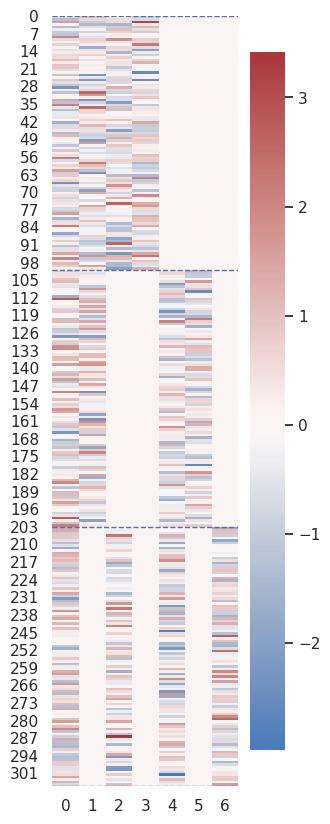

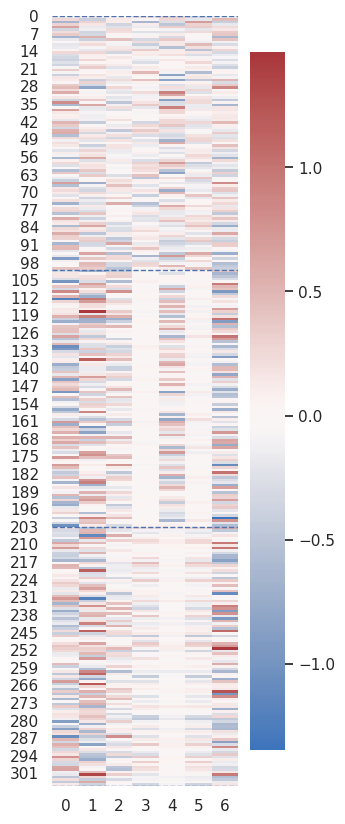

In [25]:
lined_heatmap(dg.z, figsize=(dg.n_sample_groups,10), hlines=sample_offsets, cmap="vlag", center=0)
lined_heatmap(z_hat, figsize=(dg.n_sample_groups,10), hlines=sample_offsets, cmap="vlag", center=0)

<Axes: >

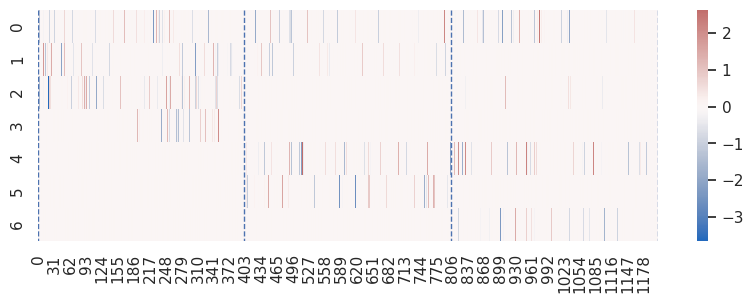

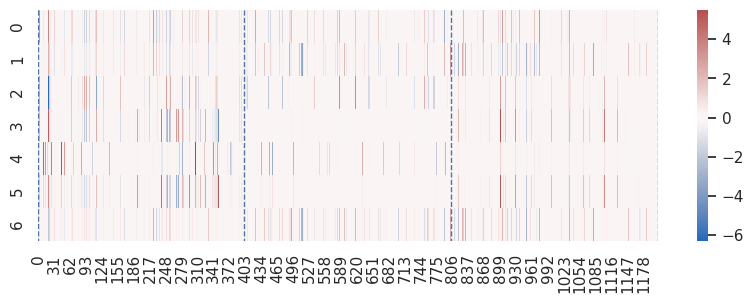

In [26]:
lined_heatmap(dg.w, figsize=(10,dg.n_feature_groups), vlines=feature_offsets, cmap="vlag", center=0)
lined_heatmap(w_hat, figsize=(10,dg.n_feature_groups), vlines=feature_offsets, cmap="vlag", center=0)